INFO:pypsa.network.io:New version 1.0.7 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'PyPSA-Eur' has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.network.io:New version 1.0.7 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'PyPSA-Eur' has buses, carriers, generators, links, loads, storage_units


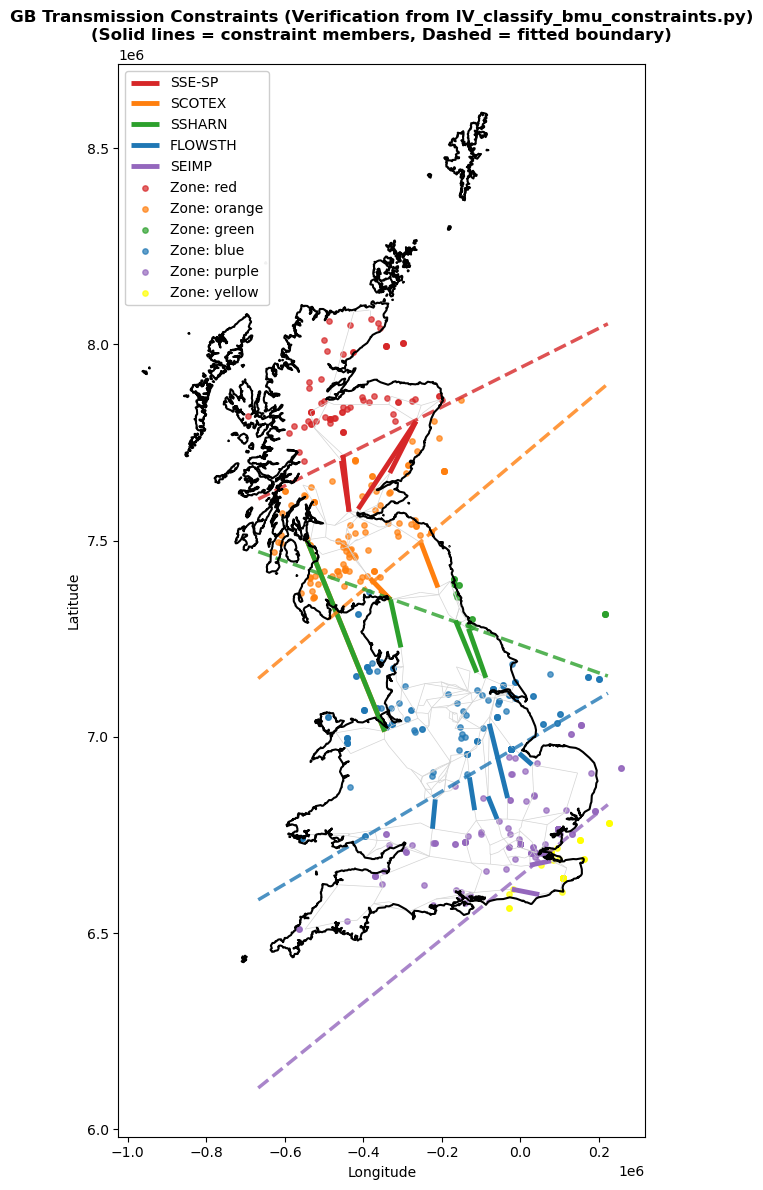


VERIFICATION: BMU Constraint Classification

SSE-SP:
  North: 66 BMUs
  South: 990 BMUs
  Boundary: lat = 0.2706 * lon + 57.8611
  Center: (-3.2343, 56.9857)

SCOTEX:
  North: 168 BMUs
  South: 888 BMUs
  Boundary: lat = 0.4736 * lon + 56.7284
  Center: (-2.9782, 55.3179)

SSHARN:
  North: 178 BMUs
  South: 878 BMUs
  Boundary: lat = -0.2053 * lon + 54.3307
  Center: (-1.8823, 54.7172)

FLOWSTH:
  North: 376 BMUs
  South: 680 BMUs
  Boundary: lat = 0.3617 * lon + 52.9646
  Center: (-0.9198, 52.6320)

SEIMP:
  North: 863 BMUs
  South: 193 BMUs
  Boundary: lat = 0.5197 * lon + 51.1117
  Center: (0.3629, 51.3003)



In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import yaml
import pypsa
from pathlib import Path

# Load the script outputs
bmu_class = pd.read_csv(
    Path.cwd().parent / 'data' / 'prerun' / 'bmu_constraint_classification.csv',
    index_col=0
)

with open(Path.cwd().parent / 'data' / 'prerun' / 'balancing_constraint_boundaries.yaml') as f:
    boundary_params = yaml.safe_load(f)

with open(Path.cwd().parent / 'data' / 'transmission_boundaries.yaml') as f:
    boundaries = yaml.safe_load(f)

# Load network and buses
n = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex_s_nodal.nc'
)
buses = pypsa.Network(Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex_s.nc').buses

# Load GB shape
gb_shape = gpd.read_file(Path.cwd().parent / 'data' / 'gb_shape.geojson')

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

constraint_order = ['SSE-SP', 'SCOTEX', 'SSHARN', 'FLOWSTH', 'SEIMP']
colors_per_constraint = {
    'SSE-SP': '#d62728',      # red
    'SCOTEX': '#ff7f0e',      # orange
    'SSHARN': '#2ca02c',      # green
    'FLOWSTH': '#1f77b4',     # blue
    'SEIMP': '#9467bd'        # purple
}

# Plot all transmission lines in light gray
if n.lines.empty:
    all_lines = n.links.loc[n.links.carrier == 'AC'].index
else:
    all_lines = n.lines.index

line_geoms = []
for l in all_lines:
    try:
        line_geoms.append(
            LineString([
                (buses.loc[n.lines.loc[str(l), 'bus0'], 'x'], buses.loc[n.lines.loc[str(l), 'bus0'], 'y']),
                (buses.loc[n.lines.loc[str(l), 'bus1'], 'x'], buses.loc[n.lines.loc[str(l), 'bus1'], 'y'])
            ])
        )
    except KeyError:
        line_geoms.append(
            LineString([
                (buses.loc[n.links.loc[str(l), 'bus0'], 'x'], buses.loc[n.links.loc[str(l), 'bus0'], 'y']),
                (buses.loc[n.links.loc[str(l), 'bus1'], 'x'], buses.loc[n.links.loc[str(l), 'bus1'], 'y'])
            ])
        )

line_gdf = gpd.GeoDataFrame(geometry=line_geoms, crs='EPSG:4326').to_crs('EPSG:3857')
line_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, zorder=1)

# Plot constraint boundary lines with colors
for constraint_name in constraint_order:
    if constraint_name not in boundaries:
        continue
    
    lines = boundaries[constraint_name]
    line_geoms = []
    
    for l in lines:
        try:
            line_geoms.append(
                LineString([
                    (buses.loc[n.lines.loc[str(l), 'bus0'], 'x'], buses.loc[n.lines.loc[str(l), 'bus0'], 'y']),
                    (buses.loc[n.lines.loc[str(l), 'bus1'], 'x'], buses.loc[n.lines.loc[str(l), 'bus1'], 'y'])
                ])
            )
        except KeyError:
            try:
                line_geoms.append(
                    LineString([
                        (buses.loc[n.links.loc[str(l), 'bus0'], 'x'], buses.loc[n.links.loc[str(l), 'bus0'], 'y']),
                        (buses.loc[n.links.loc[str(l), 'bus1'], 'x'], buses.loc[n.links.loc[str(l), 'bus1'], 'y'])
                    ])
                )
            except KeyError:
                pass
    
    if line_geoms:
        line_gdf = gpd.GeoDataFrame(geometry=line_geoms, crs='EPSG:4326').to_crs('EPSG:3857')
        line_gdf.plot(ax=ax, color=colors_per_constraint[constraint_name], linewidth=3.5, zorder=2, label=constraint_name)

# Plot fitted boundary lines using the script's boundary parameters
for constraint_name in constraint_order:
    if constraint_name not in boundary_params:
        continue
    
    params = boundary_params[constraint_name]
    slope = params['slope']
    intercept = params['intercept']
    
    # Create a line across the map using the fitted boundary equation
    lon_range = np.array([-6, 2])
    lat_range = slope * lon_range + intercept
    
    # Create LineString and project
    boundary_line = LineString([(lon_range[0], lat_range[0]), (lon_range[1], lat_range[1])])
    boundary_gdf = gpd.GeoDataFrame(geometry=[boundary_line], crs='EPSG:4326').to_crs('EPSG:3857')
    boundary_gdf.plot(ax=ax, color=colors_per_constraint[constraint_name], linewidth=2.5, linestyle='--', zorder=3, alpha=0.8)

# Plot GB shape outline
gb_shape.to_crs('EPSG:3857').plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5, zorder=5)

# Plot all BMUs colored by their geographic position relative to constraints
bmu_coords = bmu_class[['lon', 'lat']].copy()
bmu_coords = bmu_coords[(bmu_coords['lat'] != 'distributed') & (bmu_coords['lon'] != 'distributed')]
bmu_coords['lat'] = pd.to_numeric(bmu_coords['lat'], errors='coerce')
bmu_coords['lon'] = pd.to_numeric(bmu_coords['lon'], errors='coerce')
bmu_coords = bmu_coords.dropna()

# Create color map based on constraint position
color_map = {
    'red': '#d62728',      # north of SSE-SP
    'orange': '#ff7f0e',   # south of SSE-SP, north of SCOTEX
    'green': '#2ca02c',    # south of SCOTEX, north of SSHARN
    'blue': '#1f77b4',     # south of SSHARN, north of FLOWSTH
    'purple': '#9467bd',   # south of FLOWSTH, north of SEIMP
    'yellow': '#ffff00'    # south of all constraints
}

bmu_colors = []
for idx in bmu_coords.index:
    if bmu_class.loc[idx, 'SSE-SP_side'] == 'north':
        bmu_colors.append(color_map['red'])
    elif bmu_class.loc[idx, 'SCOTEX_side'] == 'north':
        bmu_colors.append(color_map['orange'])
    elif bmu_class.loc[idx, 'SSHARN_side'] == 'north':
        bmu_colors.append(color_map['green'])
    elif bmu_class.loc[idx, 'FLOWSTH_side'] == 'north':
        bmu_colors.append(color_map['blue'])
    elif bmu_class.loc[idx, 'SEIMP_side'] == 'north':
        bmu_colors.append(color_map['purple'])
    else:
        bmu_colors.append(color_map['yellow'])

if len(bmu_coords) > 0:
    bmu_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(bmu_coords['lon'], bmu_coords['lat']),
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')
    
    # Plot each color group separately
    for color_name, color_hex in color_map.items():
        mask = [c == color_hex for c in bmu_colors]
        if any(mask):
            bmu_gdf[mask].plot(ax=ax, color=color_hex, markersize=15, alpha=0.7, zorder=0, label=f'Zone: {color_name}')


ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax.set_title('GB Transmission Constraints (Verification from IV_classify_bmu_constraints.py)\n(Solid lines = constraint members, Dashed = fitted boundary)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# Print verification summary from the script outputs
print("\n" + "="*60)
print("VERIFICATION: BMU Constraint Classification")
print("="*60)

for constraint_name in constraint_order:
    side_col = f'{constraint_name}_side'
    if side_col in bmu_class.columns:
        north_count = (bmu_class[side_col] == 'north').sum()
        south_count = (bmu_class[side_col] == 'south').sum()
        print(f"\n{constraint_name}:")
        print(f"  North: {north_count} BMUs")
        print(f"  South: {south_count} BMUs")
        
        if constraint_name in boundary_params:
            params = boundary_params[constraint_name]
            print(f"  Boundary: lat = {params['slope']:.4f} * lon + {params['intercept']:.4f}")
            print(f"  Center: ({params['center_lon']:.4f}, {params['center_lat']:.4f})")

print("\n" + "="*60)